In [1]:
import pandas as pd
import numpy as np
import itertools

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import spatial

### Table with calculated mutspec for species in CytB

In [2]:
mut = pd.read_csv('../data/MutSpecVertebratescytb.csv')
mut.head()

,Species,Mut,Expected,Observed,RawMutSpec,RawMutSpecSum,MutSpec,MutBase,Context,Class
0,Abbottina_obtusirostris,T[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,TTT,Actinopterygii
1,Abbottina_obtusirostris,G[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,GTT,Actinopterygii
2,Abbottina_obtusirostris,C[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,CTT,Actinopterygii
3,Abbottina_obtusirostris,A[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,ATT,Actinopterygii
4,Abbottina_obtusirostris,T[T>C]T,8.0,0.0,0.0,1.088889,0.0,T>C,TTT,Actinopterygii


### Cancer df obtained from cancer project

In [3]:
canc_df = pd.read_csv('../data/external/cancer_mutspec.csv')
canc_df = canc_df[['Mut','MutSpec_ExDloop']]
canc_df = canc_df.rename(columns={"MutSpec_ExDloop":"MutSpec"})
canc_df['Class'] = 'Cancer'
canc_df['MutBase'] = canc_df.Mut.str.slice(2, 5)
canc_df.head()

,Mut,MutSpec,Class,MutBase
0,A[A>C]A,0.000000,Cancer,A>C
1,A[A>C]C,0.000783,Cancer,A>C
2,A[A>C]G,0.000000,Cancer,A>C
3,A[A>C]T,0.000084,Cancer,A>C
4,A[A>G]A,0.008273,Cancer,A>G


### Create vectors of orderds in heatmap and combinations

In [4]:
cl_vec = list(mut['Class'].drop_duplicates()) + ['Cancer']
correct_order = ["Actinopterygii","Amphibia", "Lepidosauria", "Mammalia", "Aves", "Cancer"]

### Function to calculate mutspec for class

In [5]:
def calc_mutspec_class(df: pd.DataFrame):
    ms_cls = df.groupby(['Class','Mut'])['RawMutSpec'].sum().reset_index()
    ms_cls["RawMutSpecSum"] = ms_cls.Class.map(ms_cls.groupby("Class").RawMutSpec.sum().to_dict())
    ms_cls['MutSpec'] = ms_cls.RawMutSpec / ms_cls.RawMutSpecSum
    ms_cls = ms_cls.drop(['RawMutSpec', 'RawMutSpecSum'], axis=1)
    
    return ms_cls

## Similarity JackKnife

Here is a function Jackknife for cosine similarity analysis. Every time we take randomly 20 species from each class and than calculate mutpsec for each class presented by those 20 species. Next do cosine similarity analysis.

In [6]:
TS_vec = ['A>G', 'G>A', 'T>C', 'C>T']
TV_vec = ['A>T', 'T>A', 'C>G', 'G>C', 'C>A', 'A>C', 'T>G', 'G>T']
def get_similarity_table(mut_df: pd.DataFrame, canc_df: pd.DataFrame, mut_type='all', n_iter=100):

    n = 0
    to_heatmap = []

    if mut_type == 'TS':
        mut_to_cos = mut_df[mut_df['MutBase'].isin(TS_vec)]
        canc_df = canc_df[canc_df['MutBase'].isin(TS_vec)]
    elif mut_type == 'TV':
        mut_to_cos = mut_df[mut_df['MutBase'].isin(TV_vec)]
        canc_df = canc_df[canc_df['MutBase'].isin(TV_vec)]
    elif mut_type =='all':
        mut_to_cos = mut_df.copy()
    else:
        raise('Error, try another MutType')
    while n < n_iter:
        for cls1 in cl_vec:
            if cls1 != 'Cancer':
                df1_sps = mut_to_cos[mut_to_cos['Class'] == cls1]['Species'].sample(n=20, replace=False)
                df1 = calc_mutspec_class(mut_to_cos[mut_to_cos['Species'].isin(df1_sps)])
            else:
                df1 = canc_df
            for cls2 in cl_vec:
                if cls1 == cls2:
                    cos192=0
                elif cls2 != 'Cancer':
                    df2_sps = mut_to_cos[mut_to_cos['Class'] == cls2]['Species'].sample(n=20, replace=False)
                    df2 = calc_mutspec_class(mut_to_cos[mut_to_cos['Species'].isin(df2_sps)])
                    cos192 = spatial.distance.cosine(df1['MutSpec'], df2['MutSpec'])
                else:
                    df2 = canc_df
                    cos192 = spatial.distance.cosine(df1['MutSpec'], df2['MutSpec'])
                    
                cos_res = {'Class1':cls1, 'Class2':cls2, 'Similarity':1-cos192}
                to_heatmap.append(cos_res)
        n += 1

    return pd.DataFrame(to_heatmap)

### JackKnife for all mutations

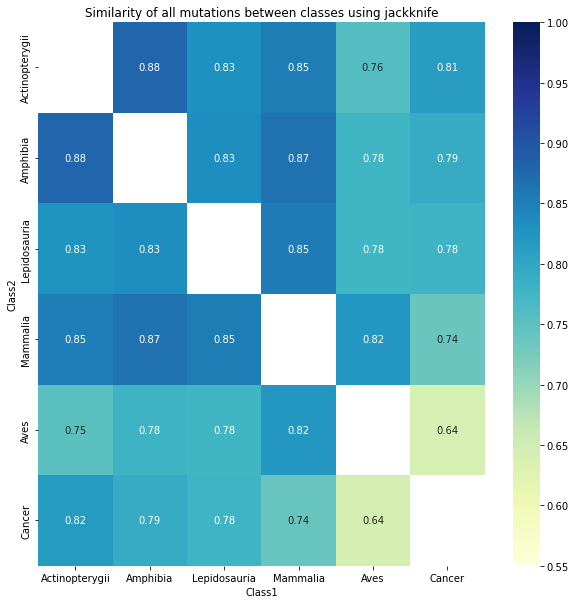

In [7]:
to_heatmap = get_similarity_table(mut_df=mut, canc_df=canc_df, mut_type='all', n_iter=1000)
to_heatmap.loc[to_heatmap['Class1'] == to_heatmap['Class2'], 'Similarity'] = np.nan
all_heatmap = to_heatmap.groupby(['Class1', 'Class2']).median().reset_index().pivot('Class2', 'Class1', 'Similarity')
all_heatmap.index = pd.CategoricalIndex(all_heatmap.index, categories=correct_order)
all_heatmap.sort_index(axis=0, inplace=True)
all_heatmap = all_heatmap.reindex(correct_order, axis=1)
plt.figure(figsize=(10, 10))
ax = sns.heatmap(all_heatmap, annot=True, cmap="YlGnBu", vmin =0.55, vmax=1)
ax.set_title('Similarity of all mutations between classes using jackknife')
plt.savefig('../pictures/HeatmapJack/Jackknife_Similarity.pdf', dpi=300)

### JackKnife for transitions only

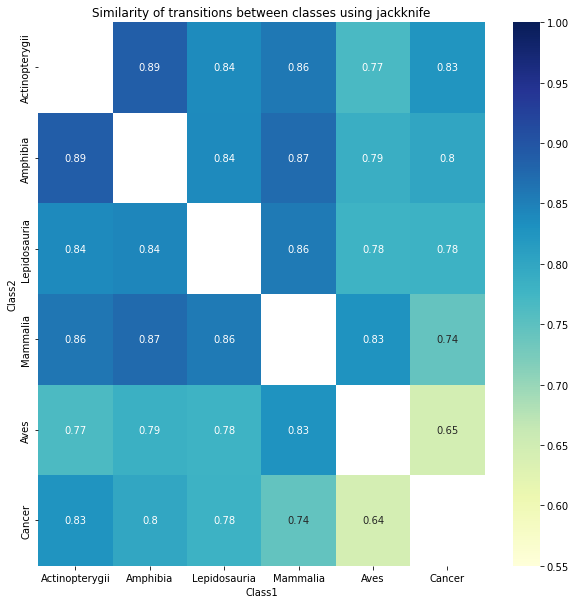

In [8]:
to_heatmap = get_similarity_table(mut_df=mut, canc_df=canc_df, mut_type='TS', n_iter=1000)
to_heatmap.loc[to_heatmap['Class1'] == to_heatmap['Class2'], 'Similarity'] = np.nan
TS_heatmap = to_heatmap.groupby(['Class1', 'Class2']).median().reset_index().pivot('Class2', 'Class1', 'Similarity')
TS_heatmap.index = pd.CategoricalIndex(TS_heatmap.index, categories=correct_order)
TS_heatmap.sort_index(level=0, inplace=True)
TS_heatmap = TS_heatmap.reindex(correct_order, axis=1)
plt.figure(figsize=(10, 10))
ax = sns.heatmap(TS_heatmap, annot=True, cmap="YlGnBu", vmin =0.55, vmax=1)
ax.set_title('Similarity of transitions between classes using jackknife')
plt.savefig('../pictures/HeatmapJack/Jackknife_SimilarityTS.pdf', dpi=300)

### JackKnife for transversions only

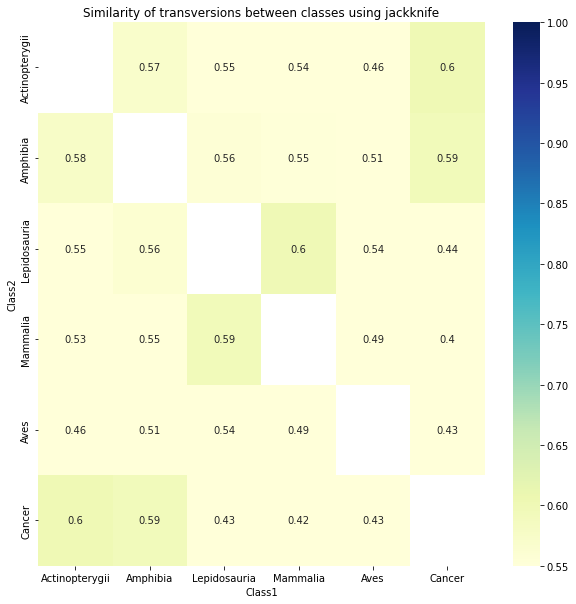

In [9]:
to_heatmap = get_similarity_table(mut_df=mut, canc_df=canc_df, mut_type='TV', n_iter=1000)
to_heatmap.loc[to_heatmap['Class1'] == to_heatmap['Class2'], 'Similarity'] = np.nan
TV_heatmap = to_heatmap.groupby(['Class1', 'Class2']).median().reset_index().pivot('Class2', 'Class1', 'Similarity')
TV_heatmap.index = pd.CategoricalIndex(TV_heatmap.index, categories= correct_order)
TV_heatmap.sort_index(level=0, inplace=True)
TV_heatmap = TV_heatmap.reindex(correct_order, axis=1)
plt.figure(figsize=(10, 10))
ax = sns.heatmap(TV_heatmap, annot=True, cmap="YlGnBu", vmin =0.55, vmax=1)
ax.set_title('Similarity of transversions between classes using jackknife')
plt.savefig('../pictures/HeatmapJack/Jackknife_SimilarityTV.pdf', dpi=300)

### Jackknife for 4 types of substituion in transitions only!

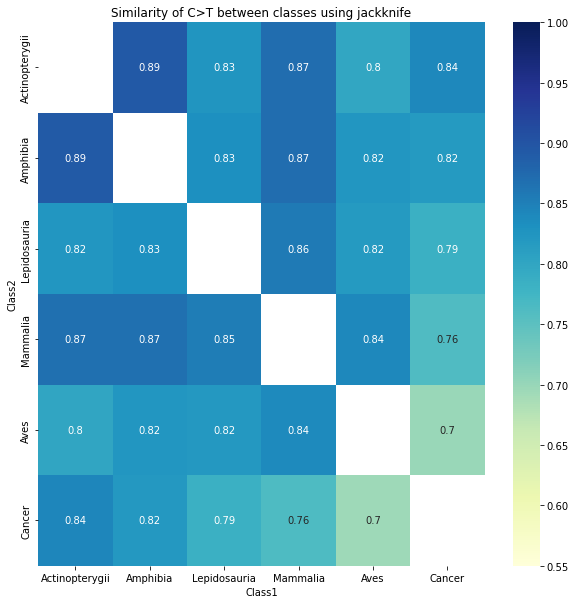

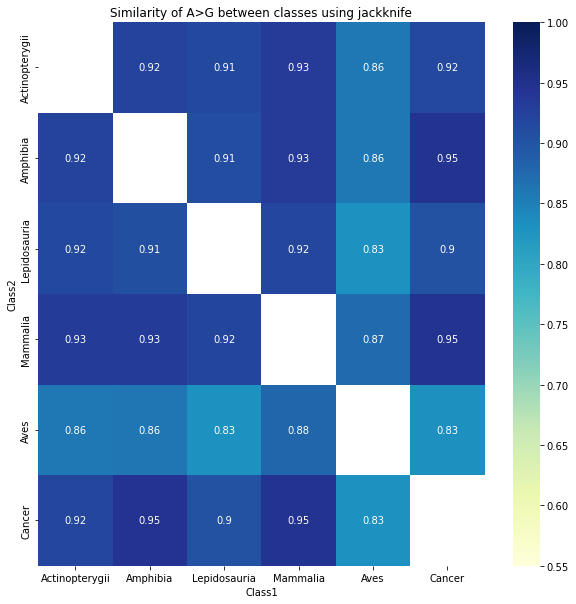

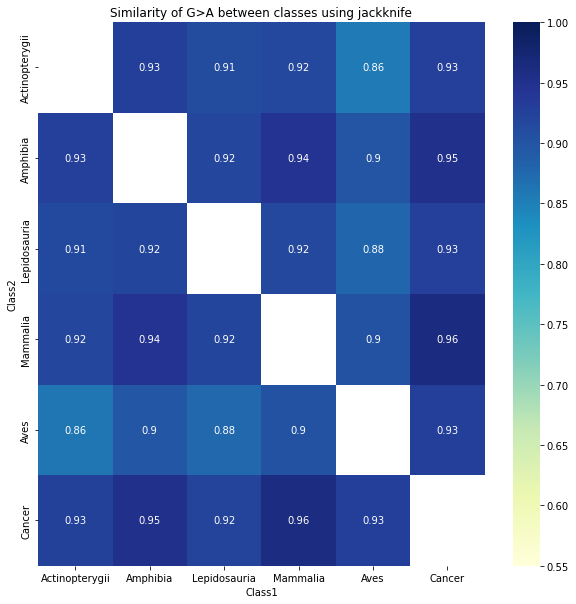

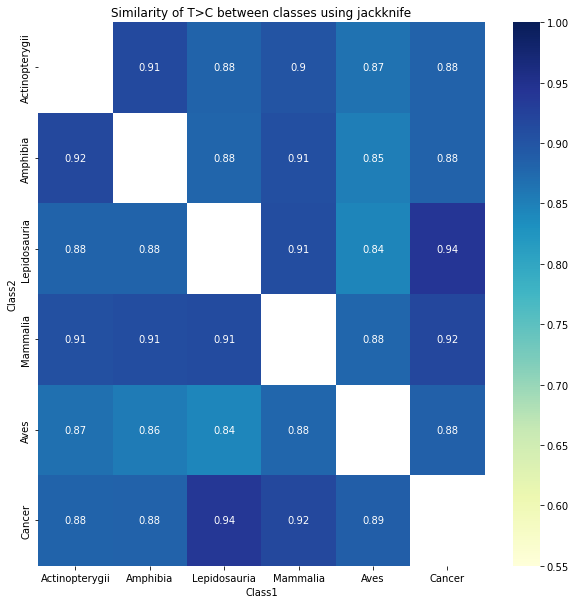

In [10]:
vec_of_subs_het = ['C>T', 'A>G', 'G>A', 'T>C']
TS_cancer = canc_df[canc_df['MutBase'].isin(TS_vec)]
TS_df = mut[mut['MutBase'].isin(TS_vec)]
for sub in vec_of_subs_het:
    needed_subs_df = TS_df[TS_df['MutBase'] == sub]
    cancer_needed_subs = TS_cancer[TS_cancer['MutBase'] == sub]
    to_heatmap = get_similarity_table(mut_df=needed_subs_df, canc_df=cancer_needed_subs, mut_type='all', n_iter=1000)
    to_heatmap.loc[to_heatmap['Class1'] == to_heatmap['Class2'], 'Similarity'] = np.nan
    sub_heatmap = to_heatmap.groupby(['Class1', 'Class2']).median().reset_index().pivot('Class2', 'Class1', 'Similarity')
    sub_heatmap.index = pd.CategoricalIndex(sub_heatmap.index, categories= correct_order)
    sub_heatmap.sort_index(level=0, inplace=True)
    sub_heatmap = sub_heatmap.reindex(correct_order, axis=1)
    plt.figure(figsize=(10, 10))
    ax = sns.heatmap(sub_heatmap, annot=True, cmap="YlGnBu", vmin =0.55, vmax=1)
    ax.set_title(f'Similarity of {sub} between classes using jackknife')
    plt.savefig(f'../pictures/HeatmapJack/Jackknife_Similarity{sub}.pdf', dpi=300)